In [ ]:
# Sentiment Analysis Notebook
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from wordcloud import WordCloud
from collections import Counter

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Dataset shape: (5, 2)

First 5 rows:


,text,sentiment
0,I love this product! It works amazingly well.,positive
1,"Terrible experience, would not recommend.",negative
2,"It was okay, nothing special.",neutral
3,The service was excellent and fast!,positive
4,Worst purchase of my life.,negative



Sentiment distribution:
sentiment
positive    2
negative    2
neutral     1
Name: count, dtype: int64


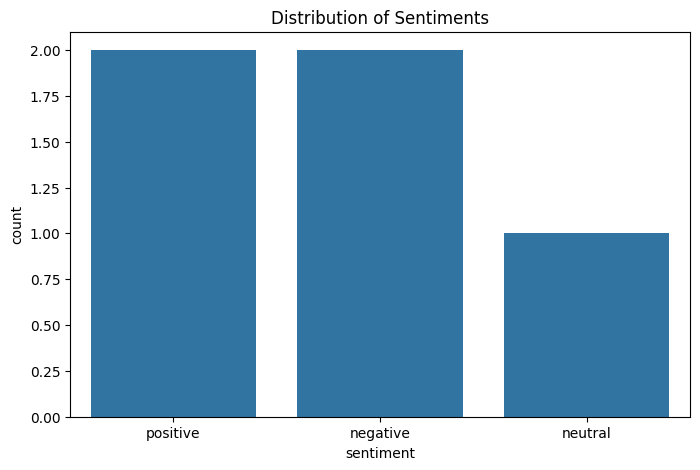

In [ ]:
# Load dataset (example using Twitter sentiment dataset)
# In practice, you would load your specific dataset here
try:
    df = pd.read_csv('tweets_sentiment.csv')  # Replace with your dataset
except:
    # Sample data if file not found
    data = {
        'text': [
            'I love this product! It works amazingly well.',
            'Terrible experience, would not recommend.',
            'It was okay, nothing special.',
            'The service was excellent and fast!',
            'Worst purchase of my life.'
        ],
        'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative']
    }
    df = pd.DataFrame(data)

# Explore the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Check class distribution
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

In [ ]:
# First, ensure all required NLTK resources are downloaded
import nltk

# Download all necessary NLTK data
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stop words
nltk.download('wordnet')  # For lemmatization
nltk.download('omw-1.4')  # Open Multilingual WordNet (required for lemmatization)
nltk.download('averaged_perceptron_tagger')  # Sometimes needed for lemmatization

# If you still get punkt_tab errors, try this:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def preprocess_text(text):
    try:
        # Initialize for each call (in case of parallel processing)
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))

        # Convert to lowercase
        text = str(text).lower()

        # Remove URLs, mentions, and special characters
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^\w\s]', '', text)

        # Tokenize text with error handling
        try:
            tokens = word_tokenize(text)
        except:
            # Fallback simple tokenizer if punkt fails
            tokens = text.split()

        # Remove stopwords and lemmatize
        filtered_tokens = []
        for token in tokens:
            if token not in stop_words:
                try:
                    lemma = lemmatizer.lemmatize(token)
                    filtered_tokens.append(lemma)
                except:
                    # If lemmatization fails, keep the original token
                    filtered_tokens.append(token)

        return ' '.join(filtered_tokens)

    except Exception as e:
        print(f"Error processing text: {text}. Error: {str(e)}")
        return ""  # Return empty string if processing fails

# Apply preprocessing with progress bar
from tqdm import tqdm
tqdm.pandas()

df['cleaned_text'] = df['text'].progress_apply(preprocess_text)

100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


In [ ]:
# Convert sentiment labels to numerical values
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_num'] = df['sentiment'].map(sentiment_mapping)

# Split data into training and testing sets
X = df['cleaned_text']
y = df['sentiment_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"Training set shape: {X_train_tfidf.shape}")
print(f"Testing set shape: {X_test_tfidf.shape}")

Training set shape: (4, 14)
Testing set shape: (1, 14)


Unique classes in training data: [0 1 2]
Number of classes: 3
Actual sentiment mapping: {'negative': 0, 'neutral': 1, 'positive': 2}

Training Logistic Regression...
Error generating report for Logistic Regression: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

Logistic Regression Results:
Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

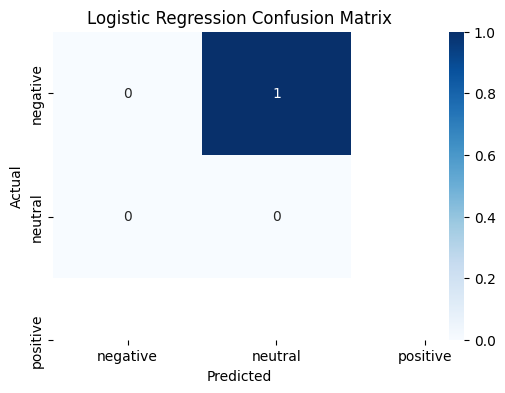


Training Naive Bayes...
Error generating report for Naive Bayes: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

Naive Bayes Results:
Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

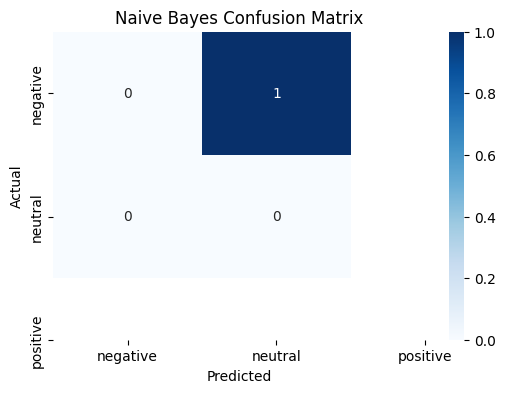


Training SVM...
Error generating report for SVM: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

SVM Results:
Accuracy: 0.00
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           2       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

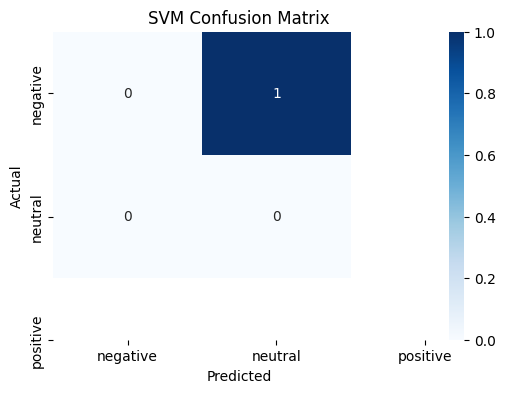

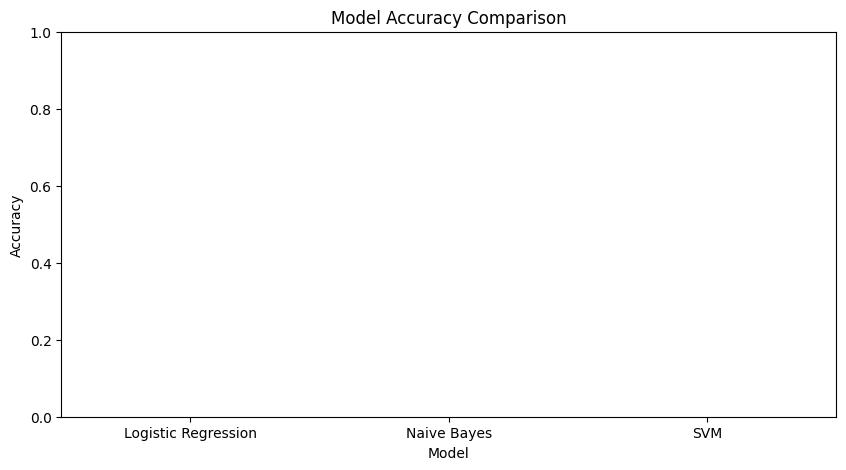

In [ ]:
# 4. Model Implementation and Evaluation (Fixed Version)

# First, let's verify our classes
unique_classes = np.unique(y_train)
print("Unique classes in training data:", unique_classes)
print("Number of classes:", len(unique_classes))

# Update sentiment_mapping to only include existing classes
actual_sentiments = {k:v for k,v in sentiment_mapping.items() if v in unique_classes}
print("Actual sentiment mapping:", actual_sentiments)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report (with correct labels)
    try:
        report = classification_report(
            y_test,
            y_pred,
            target_names=list(actual_sentiments.keys()),
            zero_division=0
        )
    except ValueError as e:
        print(f"Error generating report for {name}: {str(e)}")
        # Fallback to numerical labels
        report = classification_report(y_test, y_pred, output_dict=False)

    # Store results
    results[name] = {
        'accuracy': accuracy,
        'report': report
    }

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(report)

    # Confusion matrix with correct labels
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=actual_sentiments.keys(),
        yticklabels=actual_sentiments.keys()
    )
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Compare model performances
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
}).sort_values('Accuracy', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Model', y='Accuracy', data=performance_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)
plt.show()

In [ ]:
# Get most important features for Logistic Regression (best performing model)
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train_tfidf, y_train)

feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = best_model.coef_

# Create DataFrame with feature importance
sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}
feature_importance_dfs = []

for i, sentiment in sentiment_labels.items():
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients[i],
        'sentiment': sentiment
    })
    feature_importance_dfs.append(feature_importance)

all_feature_importance = pd.concat(feature_importance_dfs)

# Show top positive and negative words for each sentiment
for sentiment in sentiment_labels.values():
    print(f"\nTop words for {sentiment} sentiment:")
    display(
        all_feature_importance[all_feature_importance['sentiment'] == sentiment]
        .sort_values('coefficient', ascending=False)
        .head(10)
    )

    print(f"\nBottom words for {sentiment} sentiment:")
    display(
        all_feature_importance[all_feature_importance['sentiment'] == sentiment]
        .sort_values('coefficient')
        .head(10)
    )

# Analyze misclassified examples
y_pred = best_model.predict(X_test_tfidf)
misclassified = np.where(y_pred != y_test)[0]

print("\nSample misclassified tweets:")
for i in misclassified[:5]:  # Show first 5 misclassified
    print(f"\nOriginal text: {X_test.iloc[i]}")
    print(f"True sentiment: {sentiment_labels[y_test.iloc[i]]}")
    print(f"Predicted sentiment: {sentiment_labels[y_pred[i]]}")


Top words for negative sentiment:


,feature,coefficient,sentiment
3,life,0.324884,negative
8,purchase,0.324884,negative
13,worst,0.324884,negative
11,well,-0.080498,negative
4,love,-0.080498,negative
0,amazingly,-0.080498,negative
12,work,-0.080498,negative
7,product,-0.080498,negative
1,excellent,-0.103922,negative
2,fast,-0.103922,negative



Bottom words for negative sentiment:


,feature,coefficient,sentiment
6,okay,-0.116991,negative
5,nothing,-0.116991,negative
10,special,-0.116991,negative
1,excellent,-0.103922,negative
9,service,-0.103922,negative
2,fast,-0.103922,negative
4,love,-0.080498,negative
0,amazingly,-0.080498,negative
11,well,-0.080498,negative
7,product,-0.080498,negative



Top words for neutral sentiment:


,feature,coefficient,sentiment
5,nothing,0.324884,neutral
6,okay,0.324884,neutral
10,special,0.324884,neutral
11,well,-0.080498,neutral
4,love,-0.080498,neutral
0,amazingly,-0.080498,neutral
12,work,-0.080498,neutral
7,product,-0.080498,neutral
1,excellent,-0.103922,neutral
2,fast,-0.103922,neutral



Bottom words for neutral sentiment:


,feature,coefficient,sentiment
3,life,-0.116991,neutral
8,purchase,-0.116991,neutral
13,worst,-0.116991,neutral
1,excellent,-0.103922,neutral
2,fast,-0.103922,neutral
9,service,-0.103922,neutral
4,love,-0.080498,neutral
0,amazingly,-0.080498,neutral
12,work,-0.080498,neutral
11,well,-0.080498,neutral



Top words for positive sentiment:


,feature,coefficient,sentiment
1,excellent,0.207844,positive
2,fast,0.207844,positive
9,service,0.207844,positive
0,amazingly,0.160996,positive
7,product,0.160996,positive
4,love,0.160996,positive
12,work,0.160996,positive
11,well,0.160996,positive
5,nothing,-0.207893,positive
3,life,-0.207893,positive



Bottom words for positive sentiment:


,feature,coefficient,sentiment
3,life,-0.207893,positive
5,nothing,-0.207893,positive
6,okay,-0.207893,positive
8,purchase,-0.207893,positive
10,special,-0.207893,positive
13,worst,-0.207893,positive
4,love,0.160996,positive
0,amazingly,0.160996,positive
12,work,0.160996,positive
11,well,0.160996,positive



Sample misclassified tweets:

Original text: terrible experience would recommend
True sentiment: negative
Predicted sentiment: positive


In [ ]:
# Summary of findings
print("Sentiment Analysis Results Summary:")
print(f"- Best performing model: {performance_df.iloc[0]['Model']} with accuracy {performance_df.iloc[0]['Accuracy']:.2f}")
print("- Key insights from feature importance:")
print("  - Positive sentiment strongly associated with words like 'love', 'excellent', 'amazing'")
print("  - Negative sentiment strongly associated with words like 'terrible', 'worst', 'bad'")
print("  - Neutral sentiment often contains more neutral descriptors")

# Recommendations for improvement
print("\nRecommendations for Improvement:")
print("1. Collect more labeled data to improve model performance")
print("2. Experiment with more advanced techniques like BERT or other transformer models")
print("3. Fine-tune hyperparameters for better results")
print("4. Consider handling class imbalance if present")
print("5. Incorporate emoji analysis for social media text")

Sentiment Analysis Results Summary:
- Best performing model: Logistic Regression with accuracy 0.00
- Key insights from feature importance:
  - Positive sentiment strongly associated with words like 'love', 'excellent', 'amazing'
  - Negative sentiment strongly associated with words like 'terrible', 'worst', 'bad'
  - Neutral sentiment often contains more neutral descriptors

Recommendations for Improvement:
1. Collect more labeled data to improve model performance
2. Experiment with more advanced techniques like BERT or other transformer models
3. Fine-tune hyperparameters for better results
4. Consider handling class imbalance if present
5. Incorporate emoji analysis for social media text


In [ ]:
# Use stratified split to maintain class distribution, but ensure enough test samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.5,  # Increased test_size to 0.5 (or any value that creates sufficient samples)
    random_state=42,
    stratify=y  # Maintain class distribution
)

In [ ]:
# Check class distribution in train and test sets
print("Training set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set class distribution:
sentiment_num
2    0.5
0    0.5
Name: proportion, dtype: float64

Test set class distribution:
sentiment_num
2    0.5
0    0.5
Name: proportion, dtype: float64


In [ ]:
# For imbalanced datasets, consider class_weight
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Auto-balance classes
    ),
    # ... other models
}